<a href="https://colab.research.google.com/github/Robinino99/Spanish_Wine_Classification/blob/main/Project_2_Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Modeling : Spanish Wine Quality Dataset

##Data Dictionary

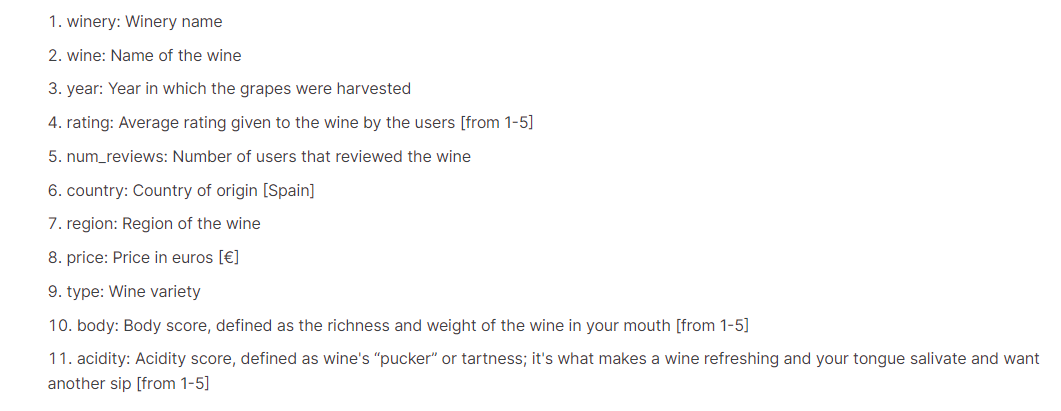

##Import packages

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [141]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Classification Metrics
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay,
                             PrecisionRecallDisplay, RocCurveDisplay,
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)

# set global Scikit-learn configuration
from sklearn import set_config

# display as a diagram
set_config(display = 'diagram')

###Add Custom Function for Visualization

In [4]:
# Univariative Plotting functions
# Basic imports for functions
#import matplotlib.pyplot as plt
#import seaborn as sns

# UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [5]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='price',figsize=(16,10),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='price',
                           figsize=(16,10)):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

In [96]:
# load in the spanish wine dataset
fpath_1 = '/content/drive/MyDrive/Coding Dojo/CodingDojo/02-MachineLearning/Week09/wines_SPA.csv'
df_1 = pd.read_csv(fpath_1)
df_1.head()


,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


###Data Cleaning

###Check for Null values

In [97]:
df_1.isna().sum()

winery            0
wine              0
year              2
rating            0
num_reviews       0
country           0
region            0
price             0
type            545
body           1169
acidity        1169
dtype: int64

###Investigate the Type feature (column)

In [98]:
# identify the number of unique values for the column/feature
df_1['type'].value_counts()

Rioja Red               2357
Ribera Del Duero Red    1407
Red                      864
Priorat Red              674
Toro Red                 296
Tempranillo              291
Sherry                   274
Albarino                 252
Mencia                   235
Rioja White               92
Pedro Ximenez             35
Grenache                  35
Cava                      33
Verdejo                   27
Monastrell                18
Montsant Red              17
Syrah                     15
Chardonnay                13
Cabernet Sauvignon        11
Sparkling                  5
Sauvignon Blanc            4
Name: type, dtype: int64

In [99]:
# filter the [type] feature where isna
df_1[df_1['type'].isna()]

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
120,Finca Moncloa,Tintilla de Rota,2016,4.7,92,Espana,Cadiz,43.13000,NaN,NaN,NaN
147,Rafael Palacios,Sorte O Soro Val do Bibei,2019,4.7,37,Espana,Valdeorras,194.86000,NaN,NaN,NaN
156,Gutierrez de la Vega,Recondita Armonia Monastrell Dulce,1987,4.7,27,Espana,Alicante,81.90000,NaN,NaN,NaN
254,Costers del Siurana,Dolc de L'Obac,2006,4.6,94,Espana,Priorato,117.23942,NaN,NaN,NaN
288,Francisco Garcia Perez,Adega do Moucho Treixadura,2017,4.6,53,Espana,Ribeiro,34.50000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7440,Binigrau,Nounat,2020,4.2,404,Espana,Mallorca,19.90000,NaN,NaN,NaN
7462,Ramon do Casar,Treixadura,2020,4.2,407,Espana,Ribeiro,11.95000,NaN,NaN,NaN
7465,Binigrau,Nounat,2020,4.2,404,Espana,Mallorca,19.90000,NaN,NaN,NaN
7487,Ramon do Casar,Treixadura,2020,4.2,407,Espana,Ribeiro,11.95000,NaN,NaN,NaN


Looking at the above output, it seems that the null values for the type feature also impact the body & acidity features. In terms of the dataset this would add no value - we shall drop these rows.

In [100]:
# drop the rows from type column where nan value
df_1.dropna(subset = ['type'], how = 'all', inplace = True)

In [101]:
# filter the [type] feature where isna
df_1['type'].isna().sum()

0

In [102]:
df_1.shape

(6955, 11)

###Drop/remove unnecessary columns

In [103]:
# drop unncessary columns
df_1 = df_1.drop(columns = ['year', 'country'])

Reason for removal.
* Year feature won't add much value to our model.
* Country column has one default value being ('Espana') - no value to our model.

In [14]:
df_1.head()

,winery,wine,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,Tinto,4.9,58,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,4.8,1705,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,4.8,1309,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [104]:
# overview of the price column
df_1['price'].describe()

count    6955.000000
mean       63.263349
std       155.636604
min         4.990000
25%        19.980000
50%        29.150000
75%        59.000000
max      3119.080000
Name: price, dtype: float64

##EDA Visualization

####Heatmap

Brief headmap to discern any correlations between features.

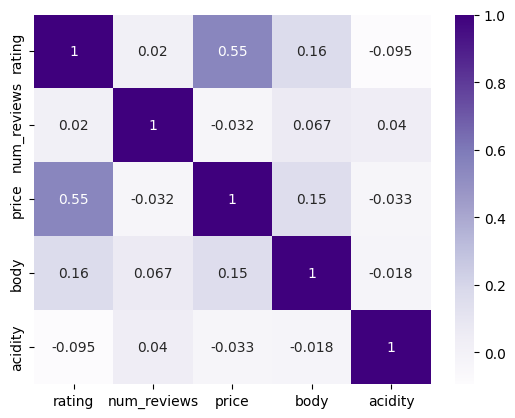

In [105]:
# plot heatmap
corr = df_1.corr(numeric_only = True)

ax = sns.heatmap(corr, cmap = 'Purples', annot = True)

Based on the above graph, there is a strong correlation with price and the rating. (0.55)


###Rating Column


In [106]:
# Evaluate the 'rating' feature
feature = 'rating'

In [107]:
# Define the type of the feature
df_1[feature].dtype

dtype('float64')

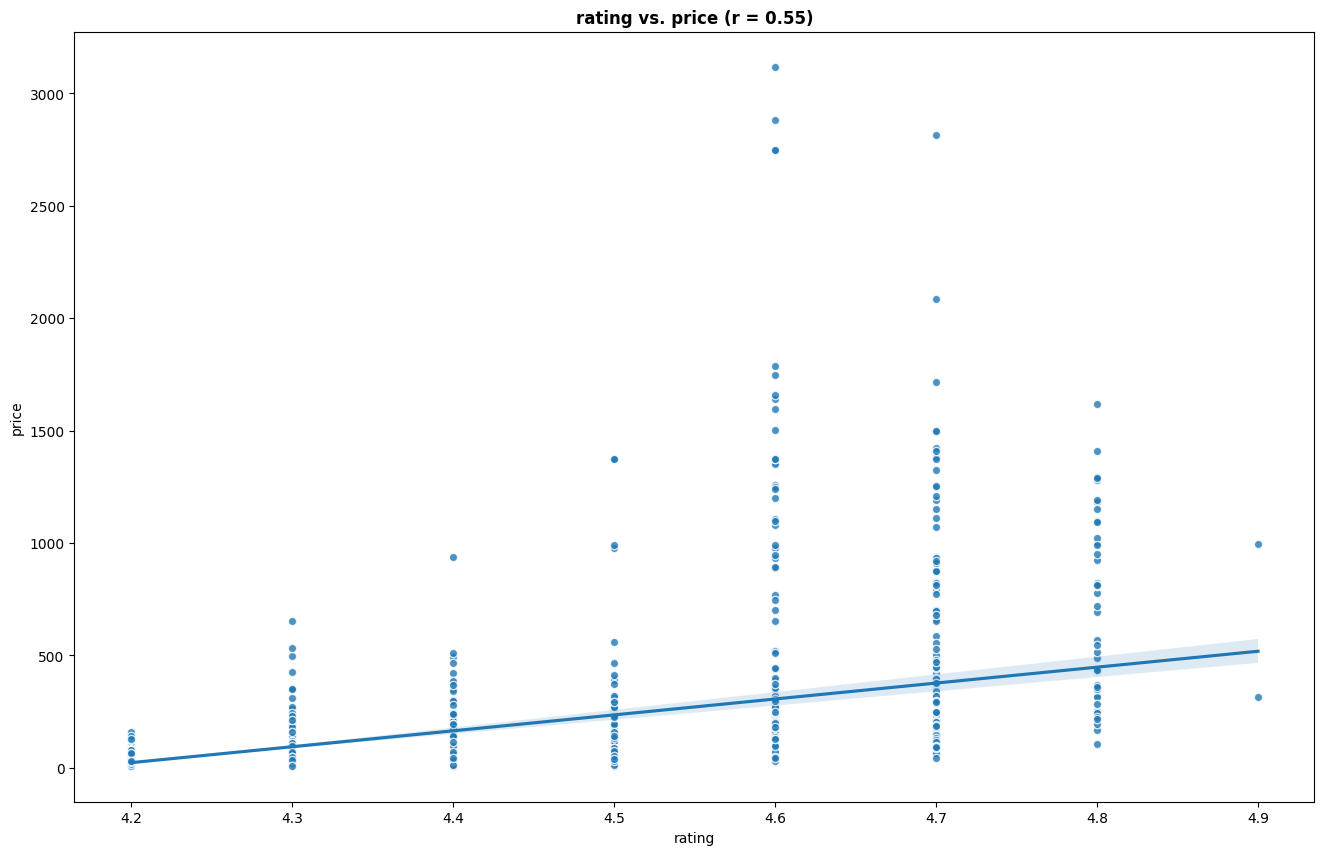

In [108]:
# run the custom function to explore the relevant column type
plot_numeric_vs_target(df_1, feature);

As we can deduce from the above graph, a higher overall product (wine) rating is not solely contingent on a more expensive wine.

The sweet spot seems be in the range of sub 500 with a 4.6 rating.

####Body Column

In [20]:
# Evaluate the 'body' feature
feature = 'body'

In [21]:
# Define the type of the feature
df_1[feature].dtype

dtype('float64')

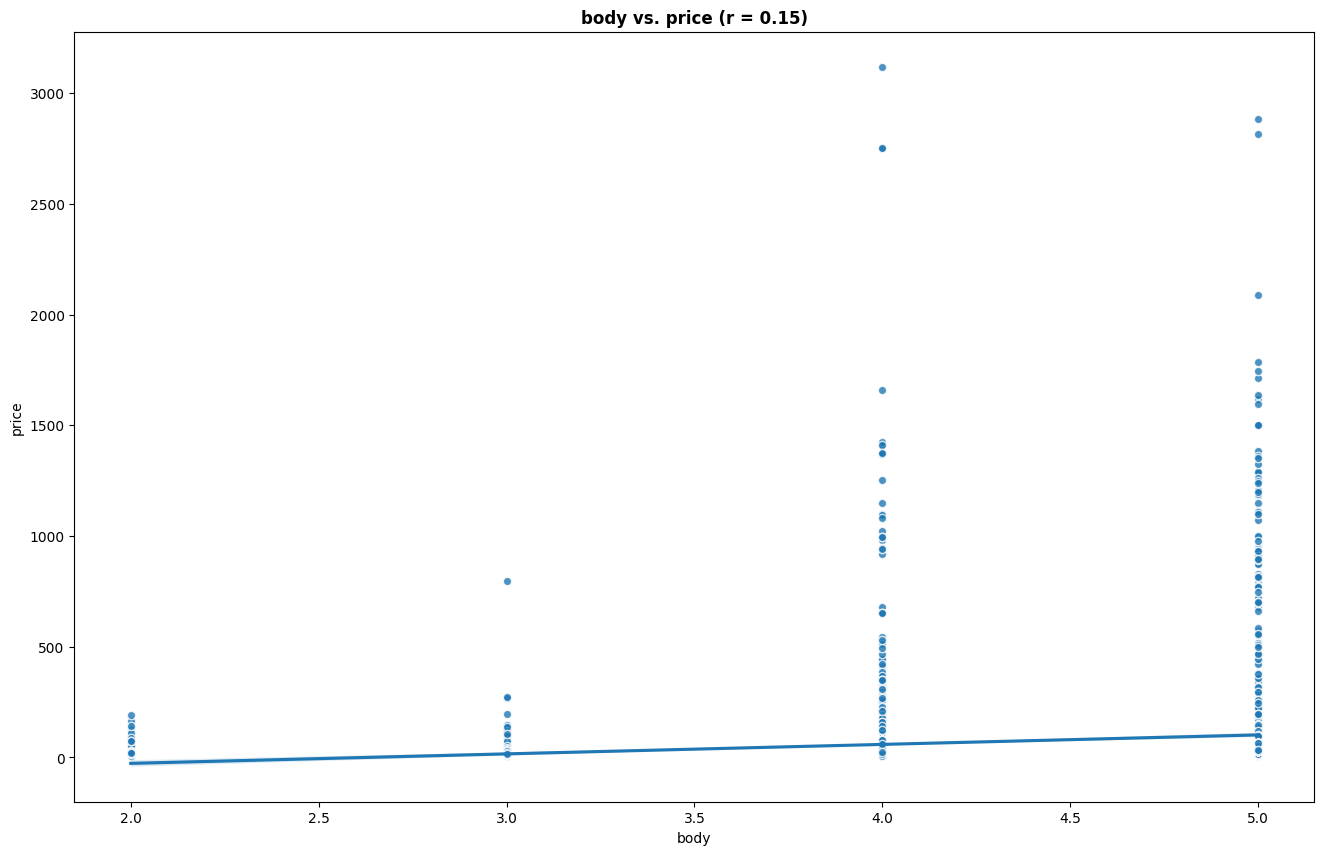

In [22]:
plot_numeric_vs_target(df_1, feature);

There seems to be little to no correlation to the body of the wine versus the price.

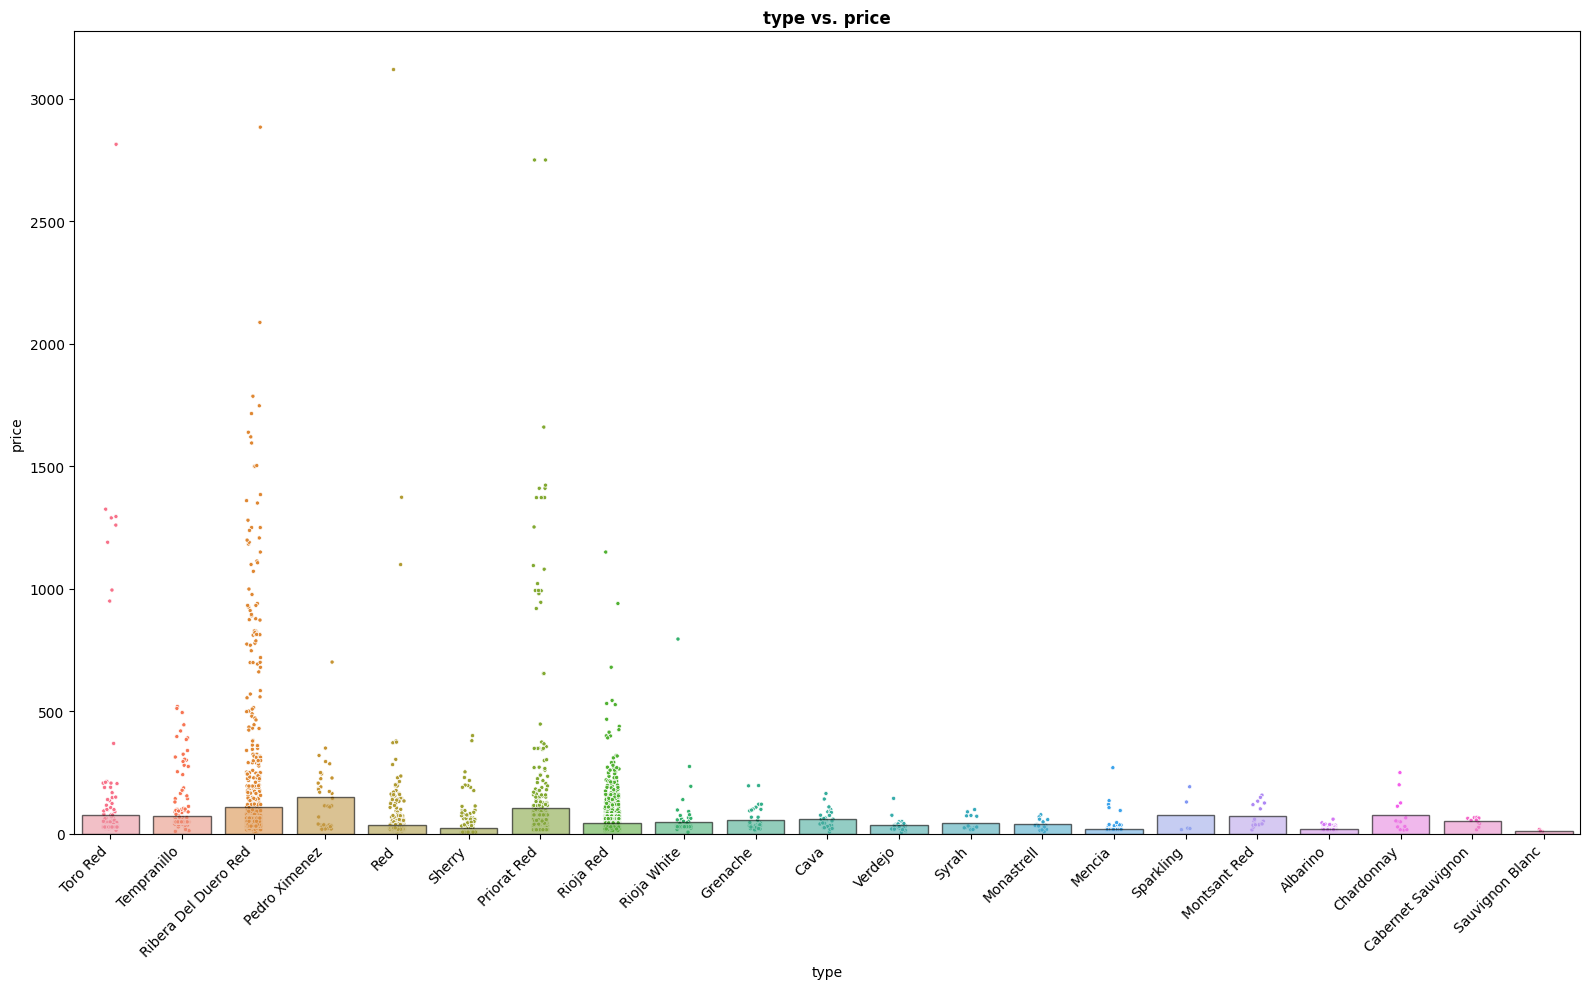

In [23]:
#

plot_categorical_vs_target(df_1, 'type');

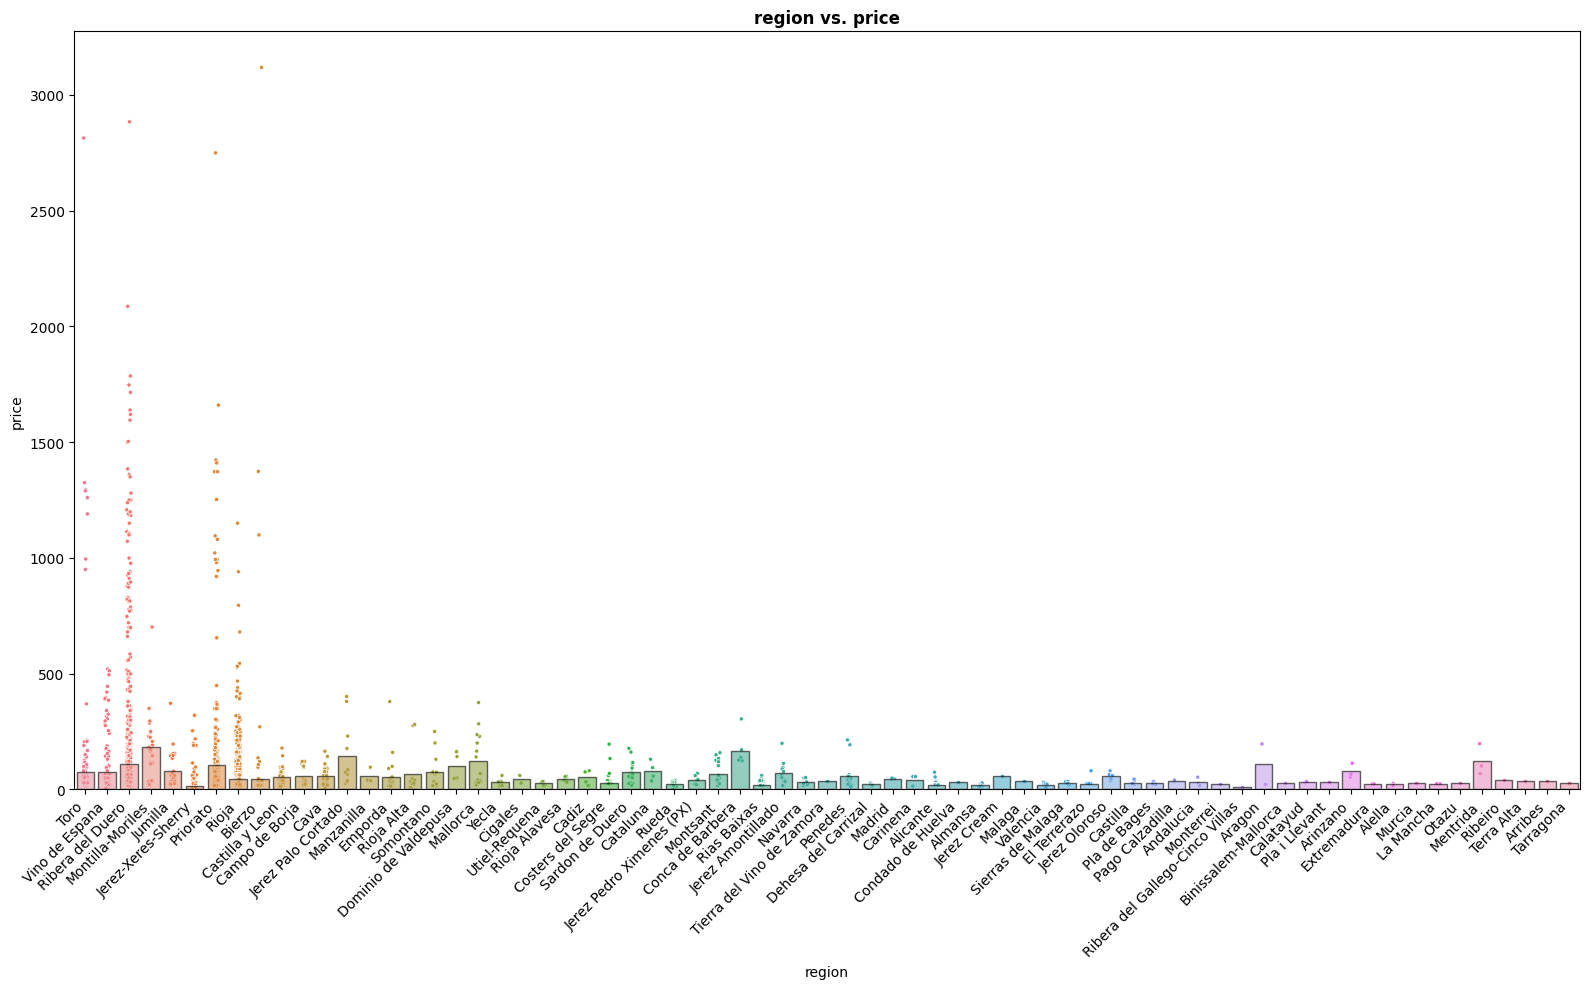

In [24]:
# Explore the region vs target
plot_categorical_vs_target(df_1, 'region');

As depicted in the above graph the following regions have the highest prices:
* Rioja
* Bierzo
* Ribera del Duero
* Vino de Espana
* Priorato

##Further Exploration

###Price Feature (Column)

In [25]:
# Group by the average rating per wine type
regional_averages = df_1.groupby('region', as_index = False).mean()

# select top 5 regions based on most expensive wines
top5_region_prices = regional_averages.nlargest(n = 5, columns = 'price')

# display top 5 regions
top5_region_prices.head()

<ipython-input-25-1db3c277e5fd>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  regional_averages = df_1.groupby('region', as_index = False).mean()


,region,rating,num_reviews,price,body,acidity
40,Montilla-Moriles,4.552000,91.520000,184.441200,5.0,1.0
18,Conca de Barbera,4.383333,192.333333,164.543333,4.0,3.0
29,Jerez Palo Cortado,4.409091,349.545455,144.475455,4.0,3.0
36,Mallorca,4.406250,152.125000,122.263498,4.0,3.0
38,Mentrida,4.300000,32.333333,121.986667,5.0,3.0


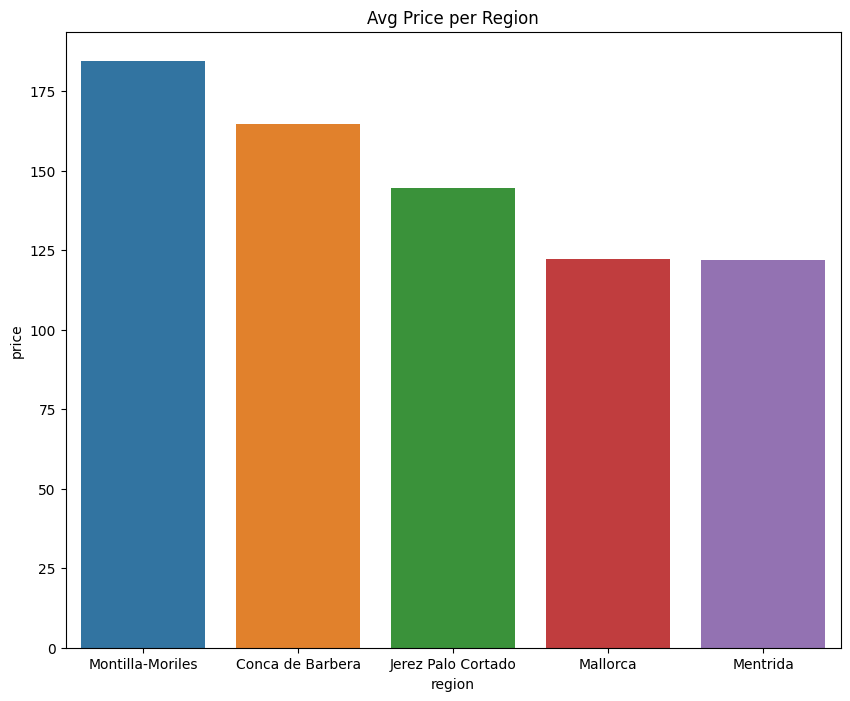

In [26]:
# visualize the top 5 regions based on price
fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(data = top5_region_prices, x = 'region', y = 'price')
ax.set_title('Avg Price per Region');


As depicted from the above graph these are the top 5 regions in terms of Wine prices.

##Modeling

In [109]:
# review the current state of the dataframe
df_1.head()

,winery,wine,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,Tinto,4.9,58,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,4.8,1705,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,4.8,1309,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [110]:
# info of the dataframe
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6955 entries, 0 to 7499
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       6955 non-null   object 
 1   wine         6955 non-null   object 
 2   rating       6955 non-null   float64
 3   num_reviews  6955 non-null   int64  
 4   region       6955 non-null   object 
 5   price        6955 non-null   float64
 6   type         6955 non-null   object 
 7   body         6331 non-null   float64
 8   acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 543.4+ KB


As shown above, both body and acidity features contain NaN values.
To ammend this we shall fill the NaN values with the most frequent value. (mode)

In [115]:
# replace NaN values with most frequent
df_1['body'] = df_1['body'].fillna(4)
df_1['acidity'] = df_1['acidity'].fillna(3)

In [116]:
# confirm there are no null/NaN values.
df_1.isna().sum()

winery         0
wine           0
rating         0
num_reviews    0
region         0
price          0
type           0
body           0
acidity        0
dtype: int64

###Train Test Split

I am going to target the [body] of wine for this classification exercise.

In [117]:
# Define X & y targets
# y target columnn
y = df_1['body']

# X target
X = df_1.drop(columns = ['body'])

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [118]:
# print the y_train to showcase class imbalance
print(f'Before sampling (target class):\n{y.value_counts(normalize=True)}')

Before sampling (target class):
4.0    0.682099
5.0    0.233501
3.0    0.079511
2.0    0.004889
Name: body, dtype: float64


As stated above the data is quite imbalanced.

We shall deal with this later.

In [119]:
X_train.head()

,winery,wine,rating,num_reviews,region,price,type,acidity
5791,Matsu,El Viejo,4.2,400,Toro,27.89,Toro Red,3.0
4157,La Rioja Alta,Vina Alberdi Crianza,4.2,410,Rioja,13.58,Rioja Red,3.0
6455,Imperial,Rioja Reserva,4.2,417,Rioja,45.00,Rioja Red,3.0
6969,Contino,Rioja Graciano,4.2,395,Rioja,61.94,Rioja Red,3.0
6524,Sei Solo,Preludio,4.2,388,Ribera del Duero,31.63,Ribera Del Duero Red,3.0


In [120]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5216 entries, 5791 to 880
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       5216 non-null   object 
 1   wine         5216 non-null   object 
 2   rating       5216 non-null   float64
 3   num_reviews  5216 non-null   int64  
 4   region       5216 non-null   object 
 5   price        5216 non-null   float64
 6   type         5216 non-null   object 
 7   acidity      5216 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 366.8+ KB


###Preprocessing

####Numeric features
* Missing values have been removed, in the original step.
* We can scale the data accordingly.

In [121]:
# Numeric Pipeline
# Save list of column names
num_cols = X_train.select_dtypes('number').columns

# We will use the imputer with the median strategy to impute missing values for the numeric column
# we will also scale the data
impute_median = SimpleImputer(strategy = 'most_frequent')
num_scaler = StandardScaler()

# Create a numeric pipeline
num_pipe = make_pipeline(impute_median, num_scaler)

# Create numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

####Categorical features
* One Hot Encode nominal features.
* Scale them accordingly.

In [122]:
# Create categorical pipeline for categorical columns []
# Save a list of categorical columns
ohe_cols = X_train.select_dtypes('object').columns
ohe_cols


# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

# Instantiate standards scaler
ohe_scaler = StandardScaler()

# Create the OHE pipeline
ohe_pipe = make_pipeline(ohe_encoder, ohe_scaler)

# Create column Transformer tuple
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

####Column Transformer

In [123]:
# Create the preprocessing ColumnTransformer
preprocessor = ColumnTransformer([num_tuple,
                                  ohe_tuple], remainder = 'drop')
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['rating', 'num_reviews', 'price', 'acidity'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['winery', 'wine', 'region', 'type'], dtype='object'))])

###Logistic Regression Model

In [124]:
# Instantiate a Logistic Regression Model, where we balance the class_weight
logreg = LogisticRegression(max_iter=500, class_weight = 'balanced')

# Create a model pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)

# Fit the logreg_pipe to our training data
logreg_pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['rating', 'num_reviews', 'price', 'acidity'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['winery', 'wine', 'region', 'type'], dtype='object'))])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [130]:
# Save the model's predictions for the train dataset
logreg_train_preds = logreg_pipe.predict(X_train)
# Save the model's predictions for the test dataset
logreg_test_preds = logreg_pipe.predict(X_test)

In [139]:
#print the classificatin report
target_labels = ['2', '3', '4', '5']
print('Logreg Train Report')
print(classification_report(y_train, logreg_train_preds, target_names = target_labels))

print('Logreg Test Report')
print(classification_report(y_test, logreg_test_preds, target_names = target_labels))

Logreg Train Report
              precision    recall  f1-score   support

           2       0.96      1.00      0.98        25
           3       0.92      1.00      0.96       400
           4       1.00      0.96      0.98      3574
           5       0.92      1.00      0.96      1217

    accuracy                           0.97      5216
   macro avg       0.95      0.99      0.97      5216
weighted avg       0.97      0.97      0.97      5216

Logreg Test Report
              precision    recall  f1-score   support

           2       0.73      0.89      0.80         9
           3       0.90      0.90      0.90       153
           4       0.97      0.95      0.96      1170
           5       0.91      0.97      0.94       407

    accuracy                           0.95      1739
   macro avg       0.88      0.93      0.90      1739
weighted avg       0.95      0.95      0.95      1739



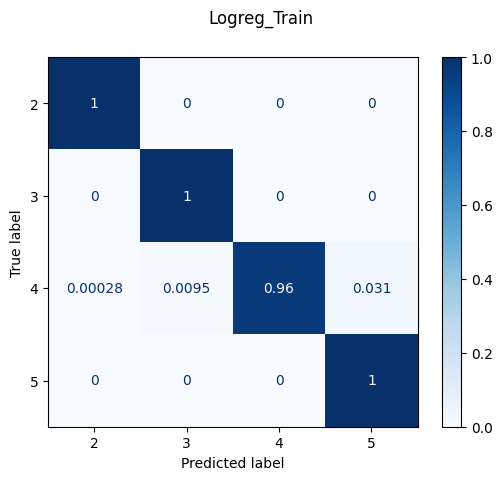

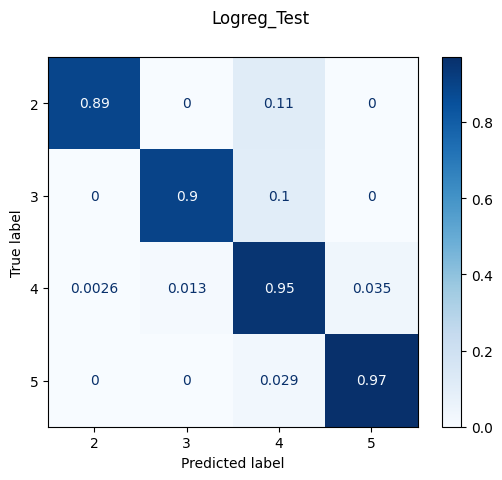

In [133]:
# create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_train, logreg_train_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Blues')
plt.suptitle('Logreg_Train');

ConfusionMatrixDisplay.from_predictions(y_test, logreg_test_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Blues')
plt.suptitle('Logreg_Test');

###KNN Model

In [136]:
# Instantiate the a default logistic regression model
knn = KNeighborsClassifier()

# Combine the preprocessing ColumnTransformer and the logistic Regression model in pipeline
knn_pipe = make_pipeline(preprocessor, knn)

# Fit the Model pipeline on the training data
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['rating', 'num_reviews', 'price', 'acidity'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['winery', 'wine', 'region', 'type'], dtype='object'))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [137]:
# Save the model's predictions for the train dataset
knn_train_preds = knn_pipe.predict(X_train)
# Save the model's predictions for the test dataset
knn_test_preds = knn_pipe.predict(X_test)

In [138]:
#print the classificatin report
print('KNN Train Report')
print(classification_report(y_train, knn_train_preds, target_names = target_labels))

print('KNN Test Report')
print(classification_report(y_test, knn_test_preds, target_names = target_labels))

KNN Train Report
              precision    recall  f1-score   support

           2       0.86      0.24      0.38        25
           3       0.91      0.94      0.92       400
           4       0.98      0.96      0.97      3574
           5       0.91      0.96      0.94      1217

    accuracy                           0.95      5216
   macro avg       0.91      0.77      0.80      5216
weighted avg       0.95      0.95      0.95      5216

KNN Test Report
              precision    recall  f1-score   support

           2       1.00      0.22      0.36         9
           3       0.89      0.88      0.89       153
           4       0.96      0.95      0.95      1170
           5       0.90      0.94      0.92       407

    accuracy                           0.94      1739
   macro avg       0.94      0.75      0.78      1739
weighted avg       0.94      0.94      0.94      1739



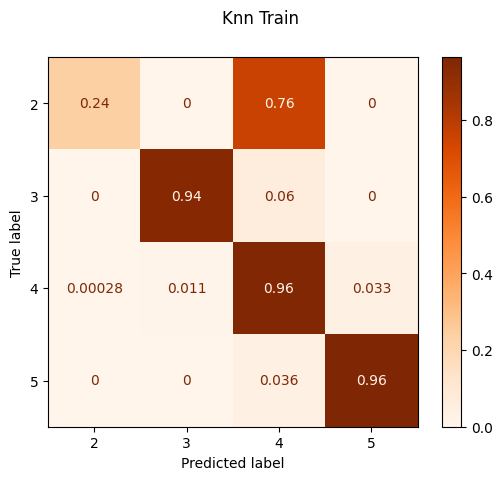

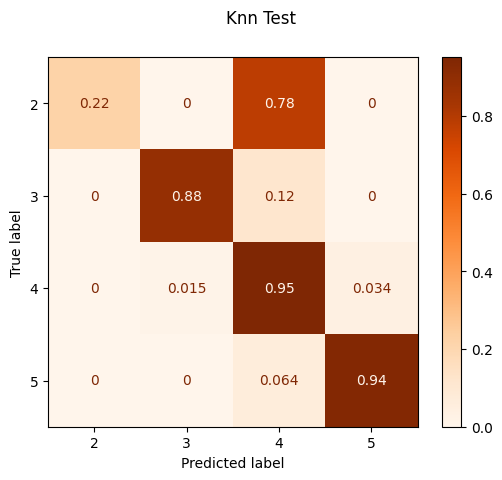

In [148]:
# create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_train, knn_train_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Oranges')
plt.suptitle('Knn Train');

ConfusionMatrixDisplay.from_predictions(y_test, knn_test_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Oranges')
plt.suptitle('Knn Test');

###Decision Tree Classifier

In [143]:
# Instantiate the Decicision Tree Classifier
dec_tree = DecisionTreeClassifier(class_weight='balanced')

# Create a new model pipeline for DecisionTree
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)

# fit DecisionTree on training data
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['rating', 'num_reviews', 'price', 'acidity'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['winery', 'wine', 'region', 'type'], dtype='object'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

In [144]:
# Save the model's predictions for the train dataset
dec_tree_train_preds = dec_tree_pipe.predict(X_train)
# Save the model's predictions for the test dataset
dec_tree_test_preds = dec_tree_pipe.predict(X_test)

In [146]:
#print the classificatin report
print('Dec_Tree Train Report')
print(classification_report(y_train, dec_tree_train_preds, target_names = target_labels))

print('Dec_Tree Test Report')
print(classification_report(y_test, dec_tree_test_preds, target_names = target_labels))

Dec_Tree Train Report
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        25
           3       0.92      1.00      0.96       400
           4       1.00      0.97      0.98      3574
           5       0.94      1.00      0.97      1217

    accuracy                           0.98      5216
   macro avg       0.97      0.99      0.98      5216
weighted avg       0.98      0.98      0.98      5216

Dec_Tree Test Report
              precision    recall  f1-score   support

           2       0.75      1.00      0.86         9
           3       0.89      0.98      0.93       153
           4       0.99      0.95      0.97      1170
           5       0.91      0.96      0.94       407

    accuracy                           0.96      1739
   macro avg       0.89      0.97      0.92      1739
weighted avg       0.96      0.96      0.96      1739



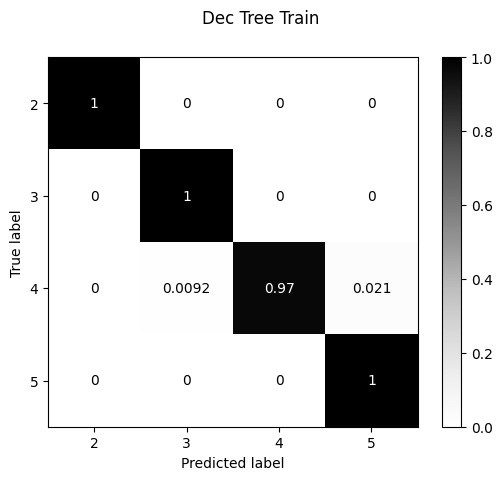

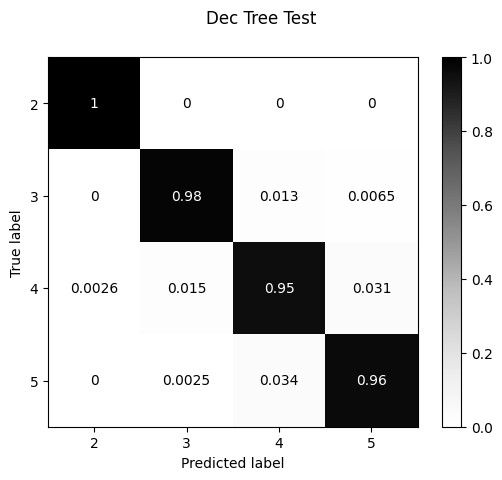

In [182]:
# create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_train, dec_tree_train_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Greys')
plt.suptitle('Dec Tree Train');

ConfusionMatrixDisplay.from_predictions(y_test, dec_tree_test_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Greys')
plt.suptitle('Dec Tree Test');

##**Interim thoughts**

3 Models chosen:
* Logistic Regression
* KNN
* Decision Tree

Of the three models - I have opted to further tune the Logistic Regression & Decision Tree model further as their f1 scores are better than the KNN model.

####Logistic Regression (Tuned)

In [151]:
# get params (logistic Regression)
logreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['rating', 'num_reviews', 'price', 'acidity'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False)),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    In

In [158]:
# create a parameter dictionary
log_reg_params = {'logisticregression__solver': ['liblinear'],
                  'logisticregression__random_state': [42]}

In [161]:
# tune via GridSearchCV
log_reg_gs = GridSearchCV(logreg_pipe, log_reg_params)
log_reg_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['rating', 'num_reviews', 'price', 'acidity'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['winery', 'wine', 'region', 'type'], dtype='object'))])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=500))]),
             param_grid={'logisticregression__random_state': [42],
                         'logisticregression__solver': ['liblinear']})

In [162]:
# get the best score
log_reg_gs.best_score_

0.9628062287168977

In [163]:
# get the best parameters
best_log_reg = log_reg_gs.best_estimator_

In [165]:
# instantiate the fit GridSearchCV
best_log_reg_train_preds = best_log_reg.predict(X_train)
best_log_reg_test_preds = best_log_reg.predict(X_test)

In [166]:
#print the classificatin report
print('Log Reg Train Report Tuned')
print(classification_report(y_train, best_log_reg_train_preds, target_names = target_labels))

print('Log RegTest Report (Tuned)')
print(classification_report(y_test, best_log_reg_test_preds, target_names = target_labels))

Log Reg Train Report Tuned
              precision    recall  f1-score   support

           2       0.96      1.00      0.98        25
           3       0.92      1.00      0.96       400
           4       1.00      0.96      0.98      3574
           5       0.92      1.00      0.96      1217

    accuracy                           0.97      5216
   macro avg       0.95      0.99      0.97      5216
weighted avg       0.97      0.97      0.97      5216

Log RegTest Report (Tuned)
              precision    recall  f1-score   support

           2       0.75      1.00      0.86         9
           3       0.91      0.96      0.93       153
           4       0.98      0.95      0.97      1170
           5       0.91      0.97      0.94       407

    accuracy                           0.96      1739
   macro avg       0.89      0.97      0.92      1739
weighted avg       0.96      0.96      0.96      1739



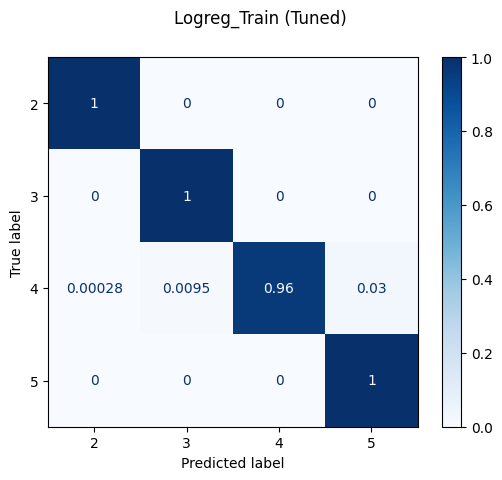

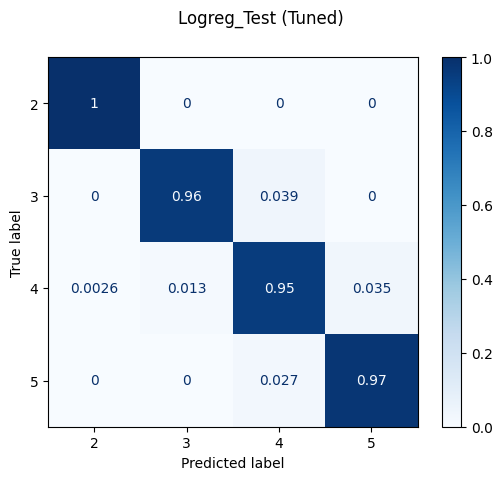

In [167]:
# create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_train, best_log_reg_train_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Blues')
plt.suptitle('Logreg_Train (Tuned)');

ConfusionMatrixDisplay.from_predictions(y_test, best_log_reg_test_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Blues')
plt.suptitle('Logreg_Test (Tuned)');

####Decision Tree (Tuned)

In [168]:
# get params (logistic Regression)
dec_tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['rating', 'num_reviews', 'price', 'acidity'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False)),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    In

In [175]:
# create a parameter dictionary
dec_tree_params = {'decisiontreeclassifier__max_leaf_nodes': [2, 3, 4],
                  'decisiontreeclassifier__min_samples_leaf': [1, 2, 3],
                  'decisiontreeclassifier__min_samples_split': [2, 3]}

In [176]:
# tune via GridSearchCV
dec_tree_gs = GridSearchCV(dec_tree_pipe, dec_tree_params)
dec_tree_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['rating', 'num_reviews', 'price', 'acidity'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_...
                                                                                                        sparse_output=False)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['winery', 'wine', 'region', 'type'], dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(class_weight='balanced'))]),
             param_grid={'decisiontreeclassifier__max_leaf_nodes': [2, 3, 4],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 3],
                         'decisiontreeclassifier__min_samples_split': [2, 3]})

In [174]:
# get the best score
dec_tree_gs.best_score_

0.6088978521285858

In [177]:
# get the best parameters
best_dec_tree = dec_tree_gs.best_estimator_

In [179]:
# instantiate the fit GridSearchCV
best_dec_tree_train_preds = best_dec_tree.predict(X_train)
best_dec_tree_test_preds = best_dec_tree.predict(X_test)

In [180]:
#print the classificatin report
print('Dec Tree Train Report Tuned')
print(classification_report(y_train, best_dec_tree_train_preds, target_names = target_labels))

print('Dec Tree Test Report (Tuned)')
print(classification_report(y_test, best_dec_tree_test_preds, target_names = target_labels))

Dec Tree Train Report Tuned
              precision    recall  f1-score   support

           2       0.96      0.88      0.92        25
           3       0.17      1.00      0.29       400
           4       1.00      0.50      0.67      3574
           5       0.91      0.79      0.84      1217

    accuracy                           0.61      5216
   macro avg       0.76      0.79      0.68      5216
weighted avg       0.91      0.61      0.68      5216

Dec Tree Test Report (Tuned)
              precision    recall  f1-score   support

           2       0.73      0.89      0.80         9
           3       0.19      1.00      0.32       153
           4       1.00      0.48      0.65      1170
           5       0.91      0.79      0.85       407

    accuracy                           0.60      1739
   macro avg       0.71      0.79      0.65      1739
weighted avg       0.91      0.60      0.67      1739



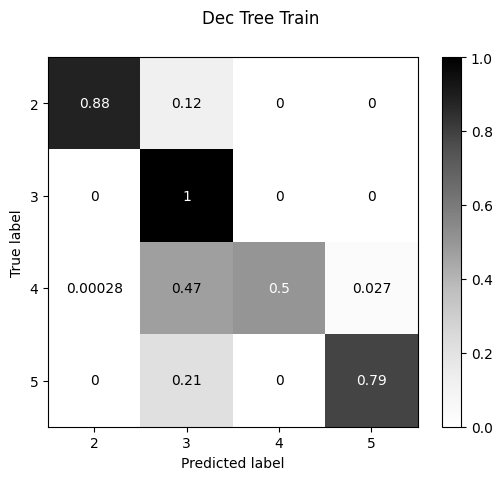

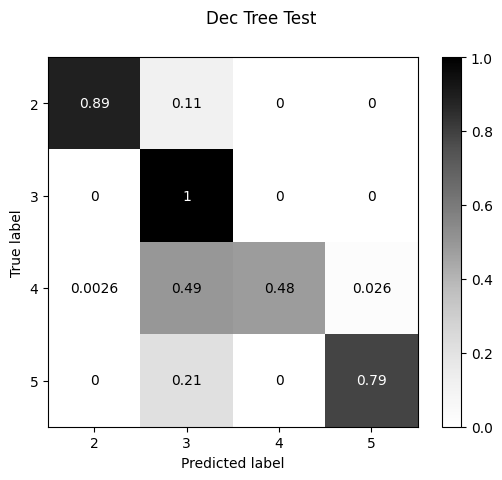

In [183]:
# create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_train, best_dec_tree_train_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Greys')
plt.suptitle('Dec Tree Train');

ConfusionMatrixDisplay.from_predictions(y_test, best_dec_tree_test_preds,
                                        normalize='true', display_labels = target_labels, cmap = 'Greys')
plt.suptitle('Dec Tree Test');

##Summary

The above exercise where in which we explored three classification models wherein which we try to determine the body value of a wine.

We have established that of the three models initially tested:
* Logistic Regression
* KNN
* Decision Tree

The KNN was not suitable for this exercise.

We opted to further tune and test the Logistic Regression and Decision Tree models.

I opted to not apply/test PCA as my dataset is quite small to begin with and the I have already removed quite a few unnecessary features.

The following findings were made:

* **Logistic Regression**
  * Initial model performed quite well on the dataset. Initial with an overal accuracy score of 95% testing data.
  * We performed tuning on the initial model. After having performed the GridSearchCV technique the model has seen improvements accross all metrics. It achieved a best score of 96% on the testing dataset.

* **Decision Tree**
  * Initial model performed well on the dataset. Intiially achieved an accuracy score of 96%.
  * However, after having performed tuning on the model it performed poorly.

Therefore in summary, I would reccomend the **Logesitc Regression model** as for this multi classification use case - it performed the best and remained consistent pre and post training. The model overall seems quite balanced.